<a href="https://colab.research.google.com/github/kinjaljoshi/s2t-training/blob/main/iter3_react.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-cloud-bigquery
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = 'llm-text-to-sql-445914'
!gcloud config set project $PROJECT_ID

Updated property [core/project].


#Base Model Test

In [ ]:
flan5_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")
# new_model = PeftModel.from_pretrained(base_model, "/content/iter2_with_react_11_epoch")

# unload_model = new_model.merge_and_unload()
flan5_model.eval()
flan5_model.to(device='cuda')

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
              (wi_1): Linear(in_features=1024, out_features=2816, bias=False)
       

In [ ]:
import json

with open("/content/warmup_react_prompts.json", "r") as file:
    input_json = json.load(file)

formatted_prompts = []
for entry in input_json:
  # if 'Retrieve' in entry['sql_prompt']:
  #       entry['sql_prompt'] = entry['sql_prompt'].replace('Retrieve', 'Find')

  # entry['sql_prompt'] = f"****Read and Understand the given question and given table or tabless and column descriptions and Write a SQL query and always use miminum 3 character aliase based on the given schema and reasoning to {entry['sql_prompt']}"

  prompt = f"""
sql_prompt:
{entry['sql_prompt']}
sql_context:
{entry['sql_context']}
Reasoning:
{entry['reasoning']}
Action:
{entry['action']}
Final Answer:
"""
  formatted_prompts.append(prompt)


In [ ]:
import json
from IPython.display import display

df_result = []
end_token_id = tokenizer.encode(";", add_special_tokens=False)[0]
for prompt in formatted_prompts:
    #parsed_prompt = prompt.strip('{}')
    # updated_text = json.dumps(f"{parsed_json} {table_prompt}")
    print(prompt)
    tokenized_prompt = tokenize_sentences_with_t5(prompt, tokenizer)
    chunks = sliding_window_tokenizer(tokenized_prompt, 512, 256)
    decoded_chunks= []
    decoded_chunks = [tokenizer.decode(chunk, skip_special_tokens=True, clean_up_tokenization_spaces=False) for chunk in chunks]
    print(f"Decoded Chunks: {decoded_chunks}")
    print(f"chunks generated = {len(chunks)}")
    responses = []

    # Process each chunk
    for chunk in chunks:
        input_chunk = {'input_ids': torch.tensor(chunk).unsqueeze(0).cuda()}

        # Generate output
        with torch.no_grad():
            outputs = flan5_model.generate(
                **input_chunk,
                max_length=256,
                num_beams=5,
                # diversity_penalty=1.2,  # Penalize repeated tokens
                # num_beam_groups=2,
    eos_token_id=tokenizer.eos_token_id,  # Stop generation at EOS token
    #do_sample=True,  # Enable sampling for diversity
    # top_k=50,  # Consider top 50 tokens
    # top_p=0.9,  # Focus on tokens with 90% cumulative probability
    # temperature=0.7  # Add randomness for diverse outputs

            )
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        #print(f"generated output - {response}")
        responses.append(response)

    # Combine responses
    if isinstance(responses, list):
        response_text = " ".join(responses)
    print(f"generated output - {responses}")

    # Extract SQL query
    match = re.search(r"SELECT.*?;", response_text, re.IGNORECASE | re.DOTALL)

    if match:
        sql_query = match.group(0).strip()
        print(f"SQL Query: {sql_query}")

    # Execute the SQL query
    #   cursor.execute(sql_query)
    #   results = cursor.fetchall()
    #   #print("Query Results:", results)
    # except sqlite3.Error as e:
    #   print(f"Error executing SQL query: {e}")
# for i, df in enumerate(df_result, start=1):
#     # print(f"DataFrame {i}:")
#     display(df)  # Displays the DataFrame in a table format



sql_prompt: 
You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions 
 #### Question:Retrieve all records from the table containing details about employees.
sql_context:

#### Table Definitions: 
 TABLE  emp_tbl 'Tracks employee details' (emp_tbl_ID 'Unique identifier for an employee', emp_tbl_NAME 'Name of the employee', EMPLOYMENT_STATUS 'Indicator if the employee is active or inactive', JOIN_DATE 'Date the employee joined');
Reasoning:
To retrieve all records, a simple SELECT statement is used. The alias emp is assigned to the table emp_tbl for readability, as per instruction to use 3-character aliases.
Action:
SELECT * FROM emp_tbl emp;
Final Answer:

Decoded Chunks: ["sql_prompt: You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions #### Question:Retrieve all records from the table containing details about employees. sql_context: #### T

# Iteration 4 merged model- no reasoning finetuned

ReACT tuning before testing

In [ ]:
!!pip uninstall -y shapely
!pip install shapely --upgrade
!pip install google-cloud-bigquery --upgrade
import nltk
nltk.download('punkt', force=True)
nltk.download('punkt_tab', force=True)
print(nltk.find('tokenizers/punkt'))
from transformers import T5ForConditionalGeneration
from peft import PeftModel
from nltk.tokenize import sent_tokenize
from transformers import T5Tokenizer
import torch, re
import pandas as pd
from peft import PeftModel
from nltk.tokenize import sent_tokenize
from transformers import T5Tokenizer
import torch, re
import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-bigquery
    Found existing installation: google-cloud-bigquery 3.25.0
    Uninstalling google-cloud-bigquery-3.25.0:
      Successfully uninstalled google-cloud-bigquery-3.25.0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


/root/nltk_data/tokenizers/punkt


In [ ]:
!gsutil -m cp -r gs://llm-pipeline-resources/models/merged_no-reasoning_iteration_4 /content/

Copying gs://llm-pipeline-resources/models/merged_no-reasoning_iteration_4/config.json...
Copying gs://llm-pipeline-resources/models/merged_no-reasoning_iteration_4/generation_config.json...
Copying gs://llm-pipeline-resources/models/merged_no-reasoning_iteration_4/model.safetensors...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

\ [3/3 files][  2.9 GiB/  2.9 GiB] 100% Done  19.0 MiB/s ETA 00:00:00           
Operation completed over 3 objects/2.9 GiB.                                      


In [ ]:
def tokenize_sentences_with_t5(text, tokenizer):
    """
    Tokenizes a long text using sentence tokenization and T5 tokenizer.

    Parameters:
        text (str): The input text to tokenize.
        tokenizer: The T5 tokenizer instance.

    Returns:
        List[int]: A single tokenized string (list of token IDs) prepared for combination.
    """
    # Sentence tokenization
    from nltk.tokenize import sent_tokenize
    sentences = sent_tokenize(text)

    # Tokenize each sentence and combine them
    tokenized_string = []
    for sentence in sentences:
        tokenized_sentence = tokenizer(sentence, add_special_tokens=False)["input_ids"]
        tokenized_string.extend(tokenized_sentence)

        # Add a space token to preserve sentence spacing
        space_token = tokenizer(" ", add_special_tokens=False)["input_ids"]
        if space_token:  # Ensure space_token is not empty
            tokenized_string.extend(space_token)

    # Remove trailing space tokens if any
    if tokenized_string:
        space_token = tokenizer(" ", add_special_tokens=False)["input_ids"]
        if space_token and tokenized_string[-len(space_token):] == space_token:
            tokenized_string = tokenized_string[:-len(space_token)]

    return tokenized_string

In [ ]:
def sliding_window_tokenizer(tokenized_string, max_length, stride):
    """
    Splits a large tokenized string into overlapping chunks using a sliding window approach.

    Parameters:
        tokenized_string (List[int]): The tokenized string (list of token IDs).
        max_length (int): Maximum allowed length for each chunk.
        stride (int): Number of tokens to overlap between consecutive chunks.

    Returns:
        List[List[int]]: A list of tokenized chunks, each with a length <= max_length.
    """
    chunks = []
    start = 0

    while start < len(tokenized_string):
        # Define the end of the current window
        end = min(start + max_length, len(tokenized_string))
        # Extract the chunk
        chunk = tokenized_string[start:end]
        chunks.append(chunk)
        # Move the window by the stride
        start += stride

    return chunks

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as PAD token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
import json

with open("/content/warmup_react_prompts.json", "r") as file:
    input_json = json.load(file)

formatted_prompts = []
for entry in input_json:
  # if 'Retrieve' in entry['sql_prompt']:
  #       entry['sql_prompt'] = entry['sql_prompt'].replace('Retrieve', 'Find')

  # entry['sql_prompt'] = f"****Read and Understand the given question and given table or tabless and column descriptions and Write a SQL query and always use miminum 3 character aliase based on the given schema and reasoning to {entry['sql_prompt']}"

  prompt = f"""
sql_prompt:
{entry['sql_prompt']}
sql_context:
{entry['sql_context']}
Reasoning:
{entry['reasoning']}
Action:
{entry['action']}
Final Answer:
"""
  formatted_prompts.append(prompt)


In [ ]:
print((formatted_prompts[29]))


sql_prompt: 
You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions 
 #### Question:Find full address of active employees
sql_context:

#### Table Definitions: 
 TABLE  emp_records_demo 'Tracks employee details' (emp_id 'Unique identifier for an employee', emp_f_name 'First Name of the employee',emp_l_name 'Last Name of the employee',STREET 'Employee Street address',E_CITY 'Employee city of address', E_STATE 'Employee state of address', E_ZIP 'Zip code of address',E_COUNTRY 'Country code',  EMPLOYMENT_STS 'Indicator if the employee is A - active or I - inactive', JOIN_DATE 'Date of joining organization of the employee');
Reasoning:
To retrieve full address of employees we need to concatinate street address, city, state, zip code and country with ||. Then we need to filter the table for employee with EMPLOYMENT_STS A.The alias emp is assigned to the table emp_records_demo for readability, as per instruction to use

In [ ]:
base_model = T5ForConditionalGeneration.from_pretrained("/content/merged_no-reasoning_iteration_4")
#new_model = PeftModel.from_pretrained(base_model, "/content/iter2_with_react_11_epoch")

#unload_model = new_model.merge_and_unload()
base_model.eval()
base_model.to(device='cuda')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
              (wi_1): Linear(in_features=1024, out_features=2816, bias=False)
       

In [ ]:
import json
from IPython.display import display

df_result = []
end_token_id = tokenizer.encode(";", add_special_tokens=False)[0]
for prompt in formatted_prompts:
    #parsed_prompt = prompt.strip('{}')
    # updated_text = json.dumps(f"{parsed_json} {table_prompt}")
    print(prompt)
    tokenized_prompt = tokenize_sentences_with_t5(prompt, tokenizer)
    chunks = sliding_window_tokenizer(tokenized_prompt, 512, 256)
    decoded_chunks= []
    decoded_chunks = [tokenizer.decode(chunk, skip_special_tokens=True, clean_up_tokenization_spaces=False) for chunk in chunks]
    print(f"Decoded Chunks: {decoded_chunks}")
    print(f"chunks generated = {len(chunks)}")
    responses = []

    # Process each chunk
    for chunk in chunks:
        input_chunk = {'input_ids': torch.tensor(chunk).unsqueeze(0).cuda()}

        # Generate output
        with torch.no_grad():
            outputs = base_model.generate(
                **input_chunk,
                max_length=256,
                num_beams=5,
                # diversity_penalty=1.2,  # Penalize repeated tokens
                # num_beam_groups=2,
    eos_token_id=tokenizer.eos_token_id,  # Stop generation at EOS token
    #do_sample=True,  # Enable sampling for diversity
    # top_k=50,  # Consider top 50 tokens
    # top_p=0.9,  # Focus on tokens with 90% cumulative probability
    # temperature=0.7  # Add randomness for diverse outputs

            )
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        #print(f"generated output - {response}")
        responses.append(response)

    # Combine responses
    if isinstance(responses, list):
        response_text = " ".join(responses)
    print(f"generated output - {responses}")

    # Extract SQL query
    match = re.search(r"SELECT.*?;", response_text, re.IGNORECASE | re.DOTALL)

    if match:
        sql_query = match.group(0).strip()
        print(f"SQL Query: {sql_query}")

    # Execute the SQL query
    #   cursor.execute(sql_query)
    #   results = cursor.fetchall()
    #   #print("Query Results:", results)
    # except sqlite3.Error as e:
    #   print(f"Error executing SQL query: {e}")
# for i, df in enumerate(df_result, start=1):
#     # print(f"DataFrame {i}:")
#     display(df)  # Displays the DataFrame in a table format



sql_prompt: 
You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions 
 #### Question:Retrieve all records from the table containing details about employees.
sql_context:

#### Table Definitions: 
 TABLE  emp_tbl 'Tracks employee details' (emp_tbl_ID 'Unique identifier for an employee', emp_tbl_NAME 'Name of the employee', EMPLOYMENT_STATUS 'Indicator if the employee is active or inactive', JOIN_DATE 'Date the employee joined');
Reasoning:
To retrieve all records, a simple SELECT statement is used. The alias emp is assigned to the table emp_tbl for readability, as per instruction to use 3-character aliases.
Action:
SELECT * FROM emp_tbl emp;
Final Answer:

Decoded Chunks: ["sql_prompt: You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions #### Question:Retrieve all records from the table containing details about employees. sql_context: #### T

In [ ]:
test_prompts = [
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Find full address of sale transactions by concatinating street, city, state, zip code, country",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
{
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Find full name of saleperson for all sale transactions, full name is concatinate first name and last name",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
  {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Get count of sales transactions",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Get count of sales transactions grouped by city and state",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Find how many sales transactions happened after item was spioled order by item name",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Find how many sales transactions happened before the item was spioled  and order by item name",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	} ,
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Find sales price for each sale transaction ?",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Find state with maximum number of sale transaction ?",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Retrieve the number of sales transaction by Salesperson first name ?",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Retrieve the number of sales transaction by sales date ?",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Retrieve the item with maximum number of sale",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Retrieve the item with maximum sale amount",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Retrieve the items that have spoiled by current date",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	}
]

In [ ]:
import json

# with open("/content/warmup_react_prompts.json", "r") as file:
#     input_json = json.load(file)

formatted_prompts = []
for entry in test_prompts:
  # if 'Retrieve' in entry['sql_prompt']:
  #       entry['sql_prompt'] = entry['sql_prompt'].replace('Retrieve', 'Find')

  # entry['sql_prompt'] = f"****Read and Understand the given question and given table or tabless and column descriptions and Write a SQL query and always use miminum 3 character aliase based on the given schema and reasoning to {entry['sql_prompt']}"

  prompt = f"""
sql_prompt:
{entry['sql_prompt']}
sql_context:
{entry['sql_context']}
Final Answer:
"""
  formatted_prompts.append(prompt)


In [ ]:
print(formatted_prompts[2])


sql_prompt: 
You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions 
 #### Question:Get count of sales transactions
sql_context:

#### Table Definitions: 
 TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');
Final Answer:



In [ ]:
import json
from IPython.display import display

df_result = []
end_token_id = tokenizer.encode(";", add_special_tokens=False)[0]
for prompt in formatted_prompts:
    #parsed_prompt = prompt.strip('{}')
    # updated_text = json.dumps(f"{parsed_json} {table_prompt}")
    print(prompt)
    tokenized_prompt = tokenize_sentences_with_t5(prompt, tokenizer)
    chunks = sliding_window_tokenizer(tokenized_prompt, 512, 256)
    decoded_chunks= []
    decoded_chunks = [tokenizer.decode(chunk, skip_special_tokens=True, clean_up_tokenization_spaces=False) for chunk in chunks]
    print(f"Decoded Chunks: {decoded_chunks}")
    print(f"chunks generated = {len(chunks)}")
    responses = []

    # Process each chunk
    for chunk in chunks:
        input_chunk = {'input_ids': torch.tensor(chunk).unsqueeze(0).cuda()}

        # Generate output
        with torch.no_grad():
            outputs = base_model.generate(
                **input_chunk,
                max_length=256,
                num_beams=5,
                # diversity_penalty=1.2,  # Penalize repeated tokens
                # num_beam_groups=2,
    eos_token_id=tokenizer.eos_token_id,  # Stop generation at EOS token
    #do_sample=True,  # Enable sampling for diversity
    # top_k=50,  # Consider top 50 tokens
    # top_p=0.9,  # Focus on tokens with 90% cumulative probability
    # temperature=0.7  # Add randomness for diverse outputs

            )
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        #print(f"generated output - {response}")
        responses.append(response)

    # Combine responses
    if isinstance(responses, list):
        response_text = " ".join(responses)
    print(f"generated output - {responses}")

    # Extract SQL query
    match = re.search(r"SELECT.*?;", response_text, re.IGNORECASE | re.DOTALL)

    if match:
        sql_query = match.group(0).strip()
        print(f"SQL Query: {sql_query}")

    # Execute the SQL query
    #   cursor.execute(sql_query)
    #   results = cursor.fetchall()
    #   #print("Query Results:", results)
    # except sqlite3.Error as e:
    #   print(f"Error executing SQL query: {e}")
# for i, df in enumerate(df_result, start=1):
#     # print(f"DataFrame {i}:")
#     display(df)  # Displays the DataFrame in a table format



sql_prompt: 
You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions 
 #### Question:Find full address of sale transactions by concatinating street, city, state, zip code, country
sql_context:

#### Table Definitions: 
 TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');
Final Answer:

Decoded Chunks: ["sql_prompt: You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Tabl

# Iteration 4 non-merged model- no reasoning finetuned

In [ ]:
#llm-pipeline-resources/models/merged_no-reasoning_iteration_4 /content/
!gsutil -m cp -r gs://llm-pipeline-resources/models/non_merged_no-reasoning_iteration_4 /content/

Copying gs://llm-pipeline-resources/models/non_merged_no-reasoning_iteration_4/adapter_config.json...
Copying gs://llm-pipeline-resources/models/non_merged_no-reasoning_iteration_4/adapter_model.safetensors...
Copying gs://llm-pipeline-resources/models/non_merged_no-reasoning_iteration_4/README.md...
\ [3/3 files][ 36.0 MiB/ 36.0 MiB] 100% Done                                    
Operation completed over 3 objects/36.0 MiB.                                     


In [ ]:
flan5_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")
#base_model = T5ForConditionalGeneration.from_pretrained("/content/merged_no-reasoning_iteration_4")
new_model = PeftModel.from_pretrained(flan5_model, "/content/non_merged_no-reasoning_iteration_4")

#unload_model = new_model.merge_and_unload()
new_model.eval()
new_model.to(device='cuda')

NameError: name 'T5ForConditionalGeneration' is not defined

In [ ]:
import json

with open("/content/warmup_react_prompts.json", "r") as file:
    input_json = json.load(file)

formatted_prompts = []
for entry in input_json:
  # if 'Retrieve' in entry['sql_prompt']:
  #       entry['sql_prompt'] = entry['sql_prompt'].replace('Retrieve', 'Find')

  # entry['sql_prompt'] = f"****Read and Understand the given question and given table or tabless and column descriptions and Write a SQL query and always use miminum 3 character aliase based on the given schema and reasoning to {entry['sql_prompt']}"

  prompt = f"""
sql_prompt:
{entry['sql_prompt']}
sql_context:
{entry['sql_context']}
Reasoning:
{entry['reasoning']}
Action:
{entry['action']}
Final Answer:
"""
  formatted_prompts.append(prompt)


In [ ]:
import json
from IPython.display import display

df_result = []
end_token_id = tokenizer.encode(";", add_special_tokens=False)[0]
for prompt in formatted_prompts:
    #parsed_prompt = prompt.strip('{}')
    # updated_text = json.dumps(f"{parsed_json} {table_prompt}")
    print(prompt)
    tokenized_prompt = tokenize_sentences_with_t5(prompt, tokenizer)
    chunks = sliding_window_tokenizer(tokenized_prompt, 512, 256)
    decoded_chunks= []
    decoded_chunks = [tokenizer.decode(chunk, skip_special_tokens=True, clean_up_tokenization_spaces=False) for chunk in chunks]
    print(f"Decoded Chunks: {decoded_chunks}")
    print(f"chunks generated = {len(chunks)}")
    responses = []

    # Process each chunk
    for chunk in chunks:
        input_chunk = {'input_ids': torch.tensor(chunk).unsqueeze(0).cuda()}

        # Generate output
        with torch.no_grad():
            outputs = new_model.generate(
                **input_chunk,
                max_length=256,
                num_beams=5,
                # diversity_penalty=1.2,  # Penalize repeated tokens
                # num_beam_groups=2,
    eos_token_id=tokenizer.eos_token_id,  # Stop generation at EOS token
    #do_sample=True,  # Enable sampling for diversity
    # top_k=50,  # Consider top 50 tokens
    # top_p=0.9,  # Focus on tokens with 90% cumulative probability
    # temperature=0.7  # Add randomness for diverse outputs

            )
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        #print(f"generated output - {response}")
        responses.append(response)

    # Combine responses
    if isinstance(responses, list):
        response_text = " ".join(responses)
    print(f"generated output - {responses}")

    # Extract SQL query
    match = re.search(r"SELECT.*?;", response_text, re.IGNORECASE | re.DOTALL)

    if match:
        sql_query = match.group(0).strip()
        print(f"SQL Query: {sql_query}")

    # Execute the SQL query
    #   cursor.execute(sql_query)
    #   results = cursor.fetchall()
    #   #print("Query Results:", results)
    # except sqlite3.Error as e:
    #   print(f"Error executing SQL query: {e}")
# for i, df in enumerate(df_result, start=1):
#     # print(f"DataFrame {i}:")
#     display(df)  # Displays the DataFrame in a table format



sql_prompt: 
You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions 
 #### Question:Retrieve all records from the table containing details about employees.
sql_context:

#### Table Definitions: 
 TABLE  emp_tbl 'Tracks employee details' (emp_tbl_ID 'Unique identifier for an employee', emp_tbl_NAME 'Name of the employee', EMPLOYMENT_STATUS 'Indicator if the employee is active or inactive', JOIN_DATE 'Date the employee joined');
Reasoning:
To retrieve all records, a simple SELECT statement is used. The alias emp is assigned to the table emp_tbl for readability, as per instruction to use 3-character aliases.
Action:
SELECT * FROM emp_tbl emp;
Final Answer:

Decoded Chunks: ["sql_prompt: You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions #### Question:Retrieve all records from the table containing details about employees. sql_context: #### T

In [ ]:
test_prompts = [
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Find full address of sale transactions by combining street, city, state, zip code, country using CONCAT",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
{
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Find full name of saleperson for all sale transactions, full name is combination of  first name and last name",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
  {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Get count of sales transactions",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Get count of sales transactions grouped by city and state",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Find how many sales transactions happened after item was spioled order by item name",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Find how many sales transactions happened before the item was spioled  and order by item name",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	} ,
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Find sales price for each sale transaction ?",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Find state with maximum number of sale transaction ?",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Retrieve the number of sales transaction by Salesperson first name ?",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Retrieve the number of sales transaction by sales date ?",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Retrieve the item with maximum number of sale",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Retrieve the item with maximum sale amount",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	},
    {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Retrieve the items that have spoiled by current date",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",

	}
]

In [ ]:
import json

# with open("/content/warmup_react_prompts.json", "r") as file:
#     input_json = json.load(file)

# formatted_prompts = []
for entry in test_prompts:
  # if 'Retrieve' in entry['sql_prompt']:
  #       entry['sql_prompt'] = entry['sql_prompt'].replace('Retrieve', 'Find')

  # entry['sql_prompt'] = f"****Read and Understand the given question and given table or tabless and column descriptions and Write a SQL query and always use miminum 3 character aliase based on the given schema and reasoning to {entry['sql_prompt']}"

  prompt = f"""
sql_prompt:
{entry['sql_prompt']}
sql_context:
{entry['sql_context']}
"""
  formatted_prompts.append(prompt)


In [ ]:
import json
from IPython.display import display

df_result = []
end_token_id = tokenizer.encode(";", add_special_tokens=False)[0]
for prompt in formatted_prompts:
    #parsed_prompt = prompt.strip('{}')
    # updated_text = json.dumps(f"{parsed_json} {table_prompt}")
    print(prompt)
    tokenized_prompt = tokenize_sentences_with_t5(prompt, tokenizer)
    chunks = sliding_window_tokenizer(tokenized_prompt, 512, 256)
    decoded_chunks= []
    decoded_chunks = [tokenizer.decode(chunk, skip_special_tokens=True, clean_up_tokenization_spaces=False) for chunk in chunks]
    #print(f"Decoded Chunks: {decoded_chunks}")
    print(f"chunks generated = {len(chunks)}")
    responses = []

    # Process each chunk
    for chunk in chunks:
        input_chunk = {'input_ids': torch.tensor(chunk).unsqueeze(0).cuda()}

        # Generate output
        with torch.no_grad():
            outputs = new_model.generate(
                **input_chunk,
                max_length=256,
                num_beams=5,
                # diversity_penalty=1.2,  # Penalize repeated tokens
                # num_beam_groups=2,
    eos_token_id=tokenizer.eos_token_id,  # Stop generation at EOS token
    #do_sample=True,  # Enable sampling for diversity
    # top_k=50,  # Consider top 50 tokens
    # top_p=0.9,  # Focus on tokens with 90% cumulative probability
    # temperature=0.7  # Add randomness for diverse outputs

            )
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        #print(f"generated output - {response}")
        responses.append(response)

    # Combine responses
    if isinstance(responses, list):
        response_text = " ".join(responses)
    #print(f"generated output - {responses}")

    # Extract SQL query
    match = re.search(r"SELECT.*?;", response_text, re.IGNORECASE | re.DOTALL)

    if match:
        sql_query = match.group(0).strip()
        print(f"SQL Query: {sql_query}")

    # Execute the SQL query
    #   cursor.execute(sql_query)
    #   results = cursor.fetchall()
    #   #print("Query Results:", results)
    # except sqlite3.Error as e:
    #   print(f"Error executing SQL query: {e}")
# for i, df in enumerate(df_result, start=1):
#     # print(f"DataFrame {i}:")
#     display(df)  # Displays the DataFrame in a table format



sql_prompt: 
You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions 
 #### Question:Retrieve all records from the table containing details about employees.
sql_context:

#### Table Definitions: 
 TABLE  emp_tbl 'Tracks employee details' (emp_tbl_ID 'Unique identifier for an employee', emp_tbl_NAME 'Name of the employee', EMPLOYMENT_STATUS 'Indicator if the employee is active or inactive', JOIN_DATE 'Date the employee joined');
Reasoning:
To retrieve all records, a simple SELECT statement is used. The alias emp is assigned to the table emp_tbl for readability, as per instruction to use 3-character aliases.
Action:
SELECT * FROM emp_tbl emp;
Final Answer:

chunks generated = 1
SQL Query: SELECT * FROM emp_tbl emp;

sql_prompt: 
You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions 
 #### Question:Find the number of records in the sales table.

In [ ]:
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11]
training_loss = [0.229800, 0.226100, 0.241900, 0.203000, 0.123200, 0.151200, 0.177600, 0.143500, 0.149800, 0.111600,0.171400]
validation_loss = [0.217012, 0.187816, 0.171798, 0.162295, 0.156578, 0.151129, 0.146232, 0.144999, 0.140892, 0.136745,0.135689]
training_rate = [5e-5, 5e-5, 5e-5, 5e-5, 5e-5, 5e-5, 5e-5, 5e-6, 5e-6, 5e-7,5e-7]


epochs_f = [1, 2, 3, 4, 5, 6, 7]
training_loss_f = [0.228100, 0.136300, 0.111200, 0.098000, 0.084100, 0.072500, 0.071200]
validation_loss_f = [0.159057, 0.135174, 0.122893, 0.117555, 0.112495, 0.113230, 0.112810]
training_rate_f = [5e-5, 5e-5, 5e-5, 5e-5, 5e-5, 5e-5, 5e-5]


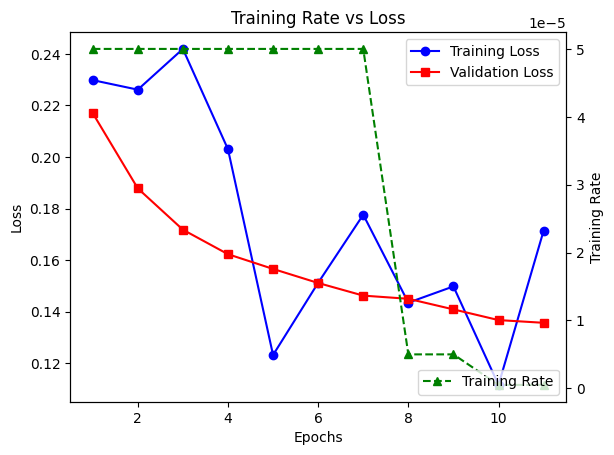

In [ ]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax1 = plt.subplots()

# Plot training and validation loss on the primary y-axis
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.plot(epochs, training_loss, label="Training Loss", color="blue", marker="o")
ax1.plot(epochs, validation_loss, label="Validation Loss", color="red", marker="s")
ax1.tick_params(axis="y")
ax1.legend(loc="upper right")

# Create a secondary y-axis for the training rate
ax2 = ax1.twinx()
ax2.set_ylabel("Training Rate")
ax2.plot(epochs, training_rate, label="Training Rate", color="green", linestyle="dashed", marker="^")
ax2.tick_params(axis="y")
ax2.legend(loc="lower right")

# Show plot
plt.title("Training Rate vs Loss")
plt.show()

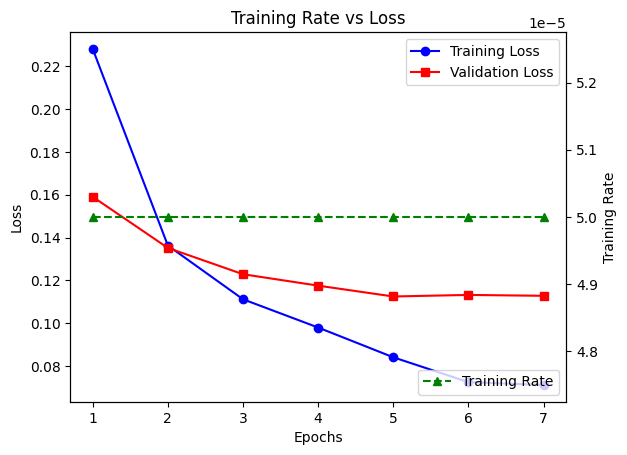

In [ ]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax5 = plt.subplots()

# Plot training and validation loss on the primary y-axis
ax5.set_xlabel("Epochs")
ax5.set_ylabel("Loss")
ax5.plot(epochs_f, training_loss_f, label="Training Loss", color="blue", marker="o")
ax5.plot(epochs_f, validation_loss_f, label="Validation Loss", color="red", marker="s")
ax5.tick_params(axis="y")
ax5.legend(loc="upper right")

# Create a secondary y-axis for the training rate
ax6 = ax5.twinx()
ax6.set_ylabel("Training Rate")
ax6.plot(epochs_f, training_rate_f, label="Training Rate", color="green", linestyle="dashed", marker="^")
ax6.tick_params(axis="y")
ax6.legend(loc="lower right")

# Show plot
plt.title("Training Rate vs Loss")
plt.show()

# **API Testing**

In [ ]:
import requests
import json

# Example API endpoint (Replace with your actual API URL)
url = "http://146.148.41.36:5002/generate"

# JSON payload (Replace with your actual input data)
data = {
    "prompt": {
        "sql_prompt": "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### Question:Retrieve the item with maximum number of sale",
        "sql_context": "\n#### Table Definitions: \n TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold');",
    }
	}

# Headers to specify JSON content
headers = {
    "Content-Type": "application/json"
}

data_str = json.dumps(data)
# Making a POST request with JSON data
response = requests.post(url, headers=headers, json=data)

# Checking if the request was successful
if response.status_code == 201:  # 201 Created is expected for successful POST requests
    print("Response Data:")
    print(json.dumps(response.json(), indent=4))  # Pretty-print JSON response
else:
    print(f"Failed to send data. Status Code: {response.status_code}")
    print(response.text)  # Print error message if any


Failed to send data. Status Code: 200
{"response":"SELECT ITEM_NAME, COUNT(*) AS TOTAL_SALES FROM TEST_SALES_TAB GROUP BY ITEM_NAME ORDER BY TOTAL_SALES DESC LIMIT 1;"}



In [ ]:
import requests
import json

# Example API endpoint (Replace with your actual API URL)
url = "http://146.148.41.36:5002/generate"

# JSON payload (Replace with your actual input data)
prompt = "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n #### "
user_question = "Retrieve the department with maximum number of employees"
s_context = """TABLE DEPT 'Contains details of department' (DEP_ID 'Unique department identifier', DEP_MGR 'Department Managet',DEP_L 'Department Location',NUM_E 'Number of employees in department');"""
data = {
    "prompt": {
        "sql_prompt": f"{prompt} {user_question}",
        "sql_context": f"\n#### Table Definitions: {s_context}",
    }
	}
print(data)
# Headers to specify JSON content
headers = {
    "Content-Type": "application/json"
}

data_str = json.dumps(data)
# Making a POST request with JSON data
response = requests.post(url, headers=headers, json=data)

# Checking if the request was successful
if response.status_code == 201:
    print("Response Data:")
    print(json.dumps(response.json(), indent=4))
else:
    print(f"Failed to send data. Status Code: {response.status_code}")
    print(response.text)  # Print error message if any


{'prompt': {'sql_prompt': "You are a SQL assistant. Generate SQL queries based on the user's request, using only the columns provided in Table Definitions \n ####  Retrieve the department with maximum number of employees", 'sql_context': "\n#### Table Definitions: TABLE DEPT 'Contains details of department' (DEP_ID 'Unique department identifier', DEP_MGR 'Department Managet',DEP_L 'Department Location',NUM_E 'Number of employees in department');"}}
Failed to send data. Status Code: 200
{"response":"SELECT DEP_MGR AS department_managed, MAX(NUM_E) AS max_employees FROM DEPT GROUP BY DEP_MGR ORDER BY max_employees DESC LIMIT 1;"}



In [ ]:
import re
def extract_question_context(user_input):
    """
    Extracts the question and context from the user input.
    Supports both multi-line and single-line formats.
    Works case-insensitively (e.g., 'QUESTION:', 'context:', 'CoNtExT:').
    """
    match = re.search(r"(?i)question\s*:\s*(.*?)\s*context\s*:\s*(.*)", user_input, re.DOTALL)

    if match:
        question = match.group(1).strip()
        context = match.group(2).strip()
        return question, context
    else:
        return None, None

In [ ]:
q,c = extract_question_context("question: Retrieve the item with maximum number of sale CONTEXT : TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold'")
print(f"Question: {q}")
print(f"Context: {c}")

Question: Retrieve the item with maximum number of sale
Context: TABLE TEST_SALES_TAB 'Contains details of sales transactions' (TRX_ID 'Unique transaction identifier', SALESPERSON_F 'First name of sales person', SALESPERSON_L 'Last name of sales person',SALE_DATE 'Date when product was sold', CODE_DATE 'Date when product is spoiled', SALE_STREET 'Street adddress of sale', SALE_CITY 'City of sale address', SALE_ZIP 'Zip code of sale address', SALE_STATE 'State of sale', COUNTRY 'Country of sale', ITEM_NAME 'Name of item sold', ITEM_QTY 'Quantity of item sold', ITEM_PRICE 'Price of each unit of item sold'
